# Data Loaders

There are two dataloaders available to make working with the provided data more straightforward. 

1. Data loader providing spectral data and labels for a single pixel. Useful for scikit-learn classifiers
2. Pytorch dataset and Pytorch Ligthning dataloader providing image chips together with labels

In this notebook we show how these dataloaders can be used.

## Pixel dataloader



In [1]:
from disfor.data import ForestDisturbanceData

The class [`ForestDisturbanceData`](disfor.data.ForestDisturbanceData) provides arguments to filter the dataset and returns class properties which can be used for training of sklearn classifiers.

In [2]:
data = ForestDisturbanceData(
    # If None, data gets dynamically downloaded and cached from Huggingface
    data_folder=None,
    # selecting healthy forest (110), clear cut (211) and bark beetle (231)
    target_classes=[110, 211, 231],
    # we remap salvage logging (221 and 222) to also be part of the clear cut class
    # this happens before filtering the target_classes. This means, that all values in the
    # mapping dict need to be in target_classes to be included
    class_mapping_overrides={221: 211, 222: 211},
    # subset to only include samples with high confidence
    confidence=["high"],
    # only include acquisitions from "leaf-on" months
    months=[5, 6, 7, 8, 9],
    # including also dark pixels (2) as valid
    valid_scl_values=[2, 4, 5, 6],
    # only include acquisitions where the clear cut is recent (maximum of 90 days),
    # for all other classes include everything
    max_days_since_event={211: 90},
    max_samples_per_event=5,
    # omit samples which have low tcd in the comment
    omit_low_tcd=True,
    # omit samples which have border in the comment
    omit_border=True,
)

Once initialized, the class instance provides train and test data as numpy arrays. 

In [3]:
print(data.y_train, data.X_train, data.y_test, data.X_test, sep="\n")

[2 0 2 ... 0 0 0]
[[1372 1478 1466 ... 3876 2721 1893]
 [ 166  310  228 ... 2732  826  367]
 [ 474  607  643 ... 1708 1812 1067]
 ...
 [ 148  230  132 ... 1515  890  462]
 [ 344  353  232 ... 1071  413  210]
 [ 241  300  178 ... 1446  691  312]]
[0 0 0 ... 0 0 0]
[[ 345  554  350 ... 2521 1182  581]
 [ 185  416  304 ... 2202 1315  682]
 [ 224  396  291 ... 2060 1204  593]
 ...
 [ 484  722  606 ... 3479 2669 1611]
 [ 246  304  291 ... 1335  885  488]
 [ 179  314  220 ... 2021 1105  575]]


It also provides the used label encoder, to go from the 0 to n-1 encoded labels back to the original labels.  

In [4]:
data.encoder.inverse_transform(data.y_test)[:10]

array([110, 110, 110, 110, 110, 211, 211, 211, 211, 211])

Now, let's quickly train a Random Forest model and validate the output:

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(oob_score=True)
rf.fit(data.X_train, data.y_train)

print(rf.oob_score_)

0.9221816011340744


The out of box accuracy for the Random Forest model is 0.92. However let's use the held out set to get a better idea of the model accuracy. For this we apply the trained model on the held out predictors (`X_test`) and derive accuracy metrics from this.

              precision    recall  f1-score   support

         110       0.93      0.98      0.95      1208
         211       0.83      0.69      0.76       147
         231       0.74      0.46      0.57        85

    accuracy                           0.92      1440
   macro avg       0.83      0.71      0.76      1440
weighted avg       0.91      0.92      0.91      1440



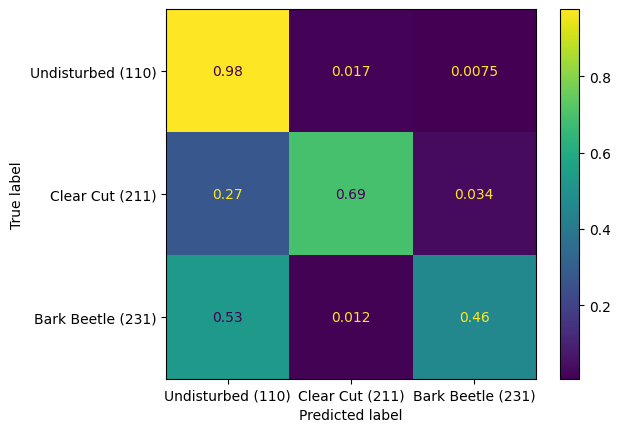

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

y_pred = rf.predict(data.X_test)
print(
    classification_report(
        data.y_test, y_pred, target_names=data.encoder.classes_.astype(str)
    )
)

disp = ConfusionMatrixDisplay.from_predictions(
    data.y_test,
    y_pred,
    display_labels=["Undisturbed (110)", "Clear Cut (211)", "Bark Beetle (231)"],
    normalize="true",
)

We can see that the undisturbed class is predicted well, however the other two classes are not predicted particularly well. Especially the precision is not great.

## Pytorch dataloader

The pytorch dataloader is used for loading image chips. If it is the first time loading the data, it will be downloaded from Huggingface. For this at least 80GB of free disk space is necessary. After the first time loading, around 35GB of space will be used. 

The first data loading can take quite some time to download and extract the data.

In [8]:
from disfor.torch import DisturbanceDataset

tiff_dataset = DisturbanceDataset(
    # If None, data gets dynamically downloaded and cached from Huggingface
    data_folder=None,
    # selecting healthy forest (110), clear cut (211) and bark beetle (231)
    target_classes=[110, 211, 231],
    # reduce the size of the chip, to include less context
    chip_size=8,
    # subset to only include samples with high confidence
    confidence=["high"],
    # only include acquisitions from "leaf-on" months
    months=[5, 6, 7, 8, 9],
    # only include acquisitions where the clear cut is recent (maximum of 90 days),
    # for all other classes include everything
    max_days_since_event={211: 90},
    max_samples_per_event=5,
    # omit samples which have low tcd in the comment
    omit_low_tcd=True,
    # omit samples which have border in the comment
    omit_border=True,
)

The dataset returns a dictionary with the image, label and path of the image.

In [9]:
tiff_dataset[0]

{'image': tensor([[[0.1408, 0.1472, 0.1444, 0.1362, 0.1326, 0.1460, 0.1572, 0.1476],
          [0.1228, 0.1318, 0.1262, 0.1302, 0.1406, 0.1448, 0.1434, 0.1378],
          [0.1142, 0.1202, 0.1210, 0.1338, 0.1434, 0.1454, 0.1332, 0.1230],
          [0.1162, 0.1238, 0.1260, 0.1362, 0.1424, 0.1424, 0.1240, 0.1202],
          [0.1098, 0.1238, 0.1224, 0.1266, 0.1372, 0.1384, 0.1258, 0.1250],
          [0.0960, 0.1090, 0.1186, 0.1176, 0.1094, 0.1046, 0.1088, 0.1176],
          [0.0958, 0.1108, 0.1238, 0.1176, 0.1024, 0.0890, 0.0924, 0.1086],
          [0.1082, 0.1146, 0.1120, 0.1054, 0.0904, 0.0709, 0.0730, 0.0836]],
 
         [[0.1684, 0.1698, 0.1746, 0.1824, 0.1826, 0.1832, 0.1828, 0.1726],
          [0.1684, 0.1684, 0.1708, 0.1632, 0.1628, 0.1740, 0.1746, 0.1660],
          [0.1592, 0.1572, 0.1536, 0.1470, 0.1480, 0.1590, 0.1616, 0.1598],
          [0.1322, 0.1396, 0.1422, 0.1416, 0.1436, 0.1436, 0.1406, 0.1460],
          [0.1278, 0.1310, 0.1370, 0.1430, 0.1478, 0.1400, 0.1318, 0.1272],


The image can also be plotted. 

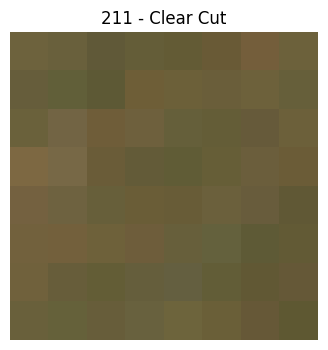

In [10]:
tiff_dataset.plot_chip(5001)

### Pytorch Lightning

For use with Pytorch Lightning, a Lightning datamodule is also available. This datamodule takes care of splitting the dataset into a training and validation set, so that the training progress can be monitored.

The datamodule only takes a few extra parameters, like `batch_size`, `num_workers` and `persist_workers`. All of the reminaing parameters are passed as keyword arguments to `TiffDataset`.

In [11]:
from disfor.torch import DisturbanceDataModule

tiff_datamodule = DisturbanceDataModule(
    batch_size=64,
    num_workers=6,
    # Keyword arguments are passed to TiffDataset
    # selecting healthy forest (110), clear cut (211) and bark beetle (231)
    target_classes=[110, 211, 231],
    # reduce the size of the chip, to include less context
    chip_size=8,
    # subset to only include samples with high confidence
    confidence=["high"],
    # only include acquisitions from "leaf-on" months
    months=[5, 6, 7, 8, 9],
    # only include acquisitions where the clear cut is recent (maximum of 90 days),
    # for all other classes include everything
    max_days_since_event={211: 90},
    max_samples_per_event=5,
    # omit samples which have low tcd in the comment
    omit_low_tcd=True,
    # omit samples which have border in the comment
    omit_border=True,
)

To test this datamodule we are defining a very simple neural network to predict classes from the input images.

In [12]:
import torch
import torch.nn as nn
import lightning as L


class SimpleClassifier(L.LightningModule):
    def __init__(self, num_classes=2, lr=1e-3):
        super().__init__()
        self.lr = lr

        # Simple feedforward network
        # Input: 10 channels * 8 * 8 = 640 features
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes),
        )

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log("train_loss", loss, prog_bar=True, batch_size=len(batch["label"]))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        logits = self(x)
        loss = self.criterion(logits, y)

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()

        self.log("val_loss", loss, prog_bar=True, batch_size=len(batch["label"]))
        self.log("val_acc", acc, prog_bar=True, batch_size=len(batch["label"]))
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

Finally we train the neural net using the data from our datamodule. As an example we are only going for 20 epochs.

In [13]:
model = SimpleClassifier(num_classes=3, lr=1e-3)

# Train with your dataloader
trainer = L.Trainer(max_epochs=20)
trainer.fit(model, datamodule=tiff_datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jonas/Documents/Projects/2025/DISFOR/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 90.5 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
90.5 K    Trainable params
0         Non-trainable params
90.5 K

/home/jonas/Documents/Projects/2025/DISFOR/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 19: 100%|██████████| 210/210 [00:09<00:00, 22.29it/s, v_num=9, train_loss=0.347, val_loss=0.221, val_acc=0.924] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 210/210 [00:09<00:00, 22.27it/s, v_num=9, train_loss=0.347, val_loss=0.221, val_acc=0.924]


Now, let's look at the confusion matrix of the trained neural net:

In [14]:
# After training, run validation and collect predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tiff_datamodule.val_dataloader():
        x, y = batch["image"], batch["label"]
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

                   precision    recall  f1-score   support

    Healthy (110)       0.93      0.99      0.96      1208
  Clear Cut (211)       0.91      0.56      0.70       147
Bark Beetle (231)       0.80      0.67      0.73        85

         accuracy                           0.92      1440
        macro avg       0.88      0.74      0.80      1440
     weighted avg       0.92      0.92      0.92      1440



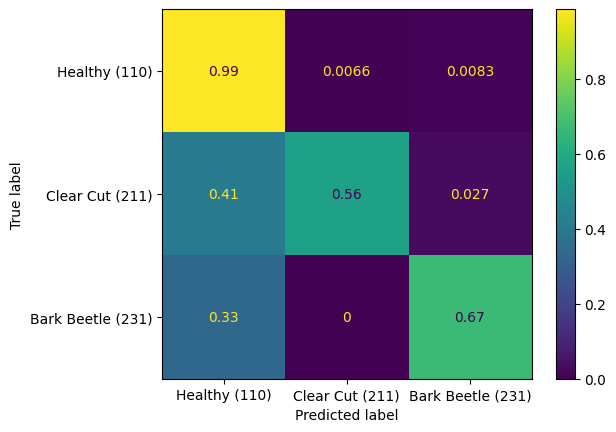

In [15]:
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=["Healthy (110)", "Clear Cut (211)", "Bark Beetle (231)"],
    )
)

disp = ConfusionMatrixDisplay.from_predictions(
    all_labels,
    all_preds,
    display_labels=["Healthy (110)", "Clear Cut (211)", "Bark Beetle (231)"],
    normalize="true",
)

After 20 epochs of training this very simple neural net, the model is outperforming the pixel based random forest model. Especially the class bark beetle is predicted more accurately. 

These models are just toy examples to show the integration of the provided datasets into training pipelines.